<a href="https://colab.research.google.com/github/4137314/HFC/blob/dev/HFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup e Caricamento Dati

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Configurazione Globale ---
DATA_DIR = './data'
TARGET_FREQ = 1.98e9  # Frequenza centrale del paper originale
MODES = ['HL', 'HU', 'RL', 'RU']

def load_csv(filename):
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        return None, None
    df = pd.read_csv(path, sep=';', quotechar='"')
    df.columns = [c.strip() for c in df.columns]
    return df.iloc[:, 0].values, df.iloc[:, 1].values

print("Setup completato. Pronto per l'analisi.")

Setup completato. Pronto per l'analisi.


# Analisi del Matching (S11)

## Multi-mode S11 Plot

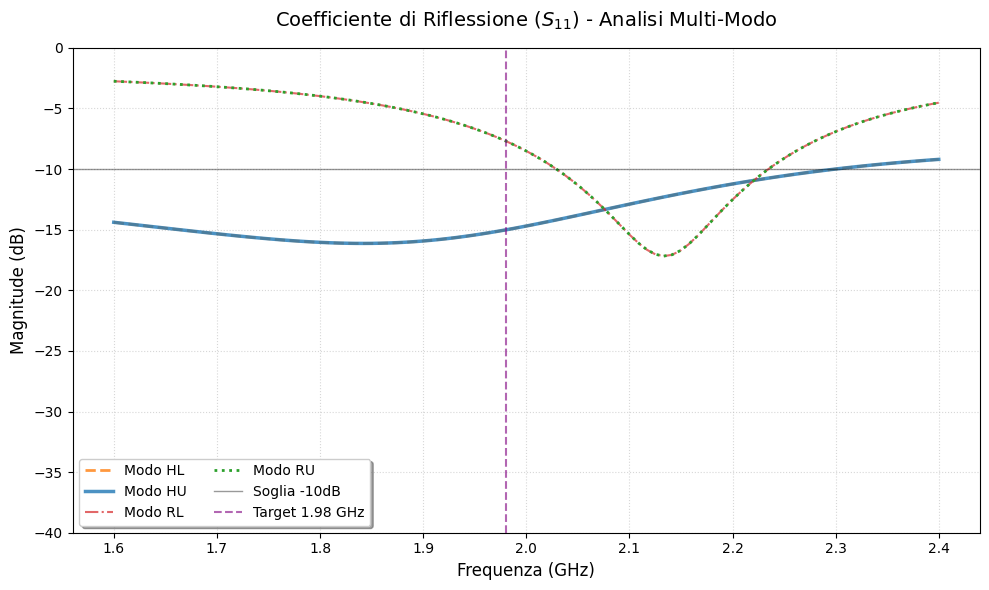

In [6]:
plt.figure(figsize=(10, 6))

# Definiamo stili diversi per distinguere i modi anche se sovrapposti
line_styles = {
    'HU': {'color': '#1f77b4', 'ls': '-',  'lw': 2.5, 'alpha': 0.8}, # Blu continuo (spesso)
    'HL': {'color': '#ff7f0e', 'ls': '--', 'lw': 2.0, 'alpha': 0.8}, # Arancio tratteggiato
    'RU': {'color': '#2ca02c', 'ls': ':',  'lw': 2.0, 'alpha': 1.0}, # Verde puntinato
    'RL': {'color': '#d62728', 'ls': '-.', 'lw': 1.5, 'alpha': 0.7}  # Rosso tratto-punto
}

for m in MODES:
    f, s11 = load_csv(f'{m}_S11.csv')
    if f is not None:
        # Recuperiamo lo stile specifico per il modo o usiamo un default
        style = line_styles.get(m, {'ls': '-', 'lw': 1.5, 'alpha': 1.0})

        plt.plot(f/1e9, s11, label=f'Modo {m}',
                 linestyle=style['ls'],
                 linewidth=style['lw'],
                 alpha=style['alpha'],
                 color=style.get('color'))

# Linee di riferimento
plt.axhline(-10, color='black', linestyle='-', linewidth=1, alpha=0.4, label='Soglia -10dB')
plt.axvline(TARGET_FREQ/1e9, color='purple', linestyle='--', alpha=0.6, label=f'Target {TARGET_FREQ/1e9:.2f} GHz')

# Miglioramento della griglia e dei dettagli
plt.title("Coefficiente di Riflessione ($S_{11}$) - Analisi Multi-Modo", fontsize=14, pad=15)
plt.ylabel("Magnitude (dB)", fontsize=12)
plt.xlabel("Frequenza (GHz)", fontsize=12)
plt.ylim(-40, 0)
plt.grid(True, which='both', linestyle=':', alpha=0.5)

# Legenda posizionata in un punto che solitamente non copre i minimi (risonanze)
plt.legend(loc='lower left', frameon=True, shadow=True, ncol=2)

plt.tight_layout()
plt.savefig('S11_all_modes_distinguishable.png', dpi=300)
plt.show()

Sovrapposzione perfetta

## Calcolo della Fractional Bandwidth (FBW)

In [7]:
print(f"{'Modo':<10} | {'f_min (GHz)':<12} | {'f_max (GHz)':<12} | {'FBW (%)':<10}")
print("-" * 55)

fbw_results = {}

for m in MODES:
    f, s11 = load_csv(f'{m}_S11.csv')
    if f is not None:
        # Trova gli indici dove S11 è sotto la soglia di -10 dB
        under_threshold = np.where(s11 <= -10)[0]

        if len(under_threshold) > 0:
            f_min = f[under_threshold[0]]
            f_max = f[under_threshold[-1]]
            f_center = (f_max + f_min) / 2

            # Calcolo FBW
            fbw = ((f_max - f_min) / f_center) * 100
            fbw_results[m] = fbw

            print(f"{m:<10} | {f_min/1e9:<12.3f} | {f_max/1e9:<12.3f} | {fbw:<10.2f}%")
        else:
            print(f"{m:<10} | {'N/A':<12} | {'N/A':<12} | {'0.00':<10}%")

# Nota: confronta questi valori con il 6.5% riportato nel paper per i modi circolari.

Modo       | f_min (GHz)  | f_max (GHz)  | FBW (%)   
-------------------------------------------------------
HL         | 1.600        | 2.295        | 35.68     %
HU         | 1.600        | 2.295        | 35.68     %
RL         | 2.036        | 2.230        | 9.09      %
RU         | 2.036        | 2.230        | 9.09      %


## Verifica della stabilità

In [8]:
print(f"{'Modo':<10} | {'f_res (GHz)':<12} | {'S11 min (dB)':<12} | {'Delta f (MHz)':<12}")
print("-" * 60)

# Calcoliamo la frequenza di risonanza media come riferimento
res_frequencies = []
results = []

for m in MODES:
    f, s11 = load_csv(f'{m}_S11.csv')
    if f is not None:
        idx_min = np.argmin(s11)
        f_res = f[idx_min]
        s11_min = s11[idx_min]
        res_frequencies.append(f_res)
        results.append((m, f_res, s11_min))

f_mean = np.mean(res_frequencies)

for m, f_res, s11_min in results:
    delta_f = (f_res - f_mean) / 1e6  # Shift in MHz rispetto alla media
    print(f"{m:<10} | {f_res/1e9:<12.3f} | {s11_min:<12.2f} | {delta_f:<+12.2f}")

max_shift = (np.max(res_frequencies) - np.min(res_frequencies)) / 1e6
print("-" * 60)
print(f"Shift massimo tra le modalità: {max_shift:.2f} MHz")

if max_shift < 50: # Soglia tipica per sistemi a 2GHz
    print("Esito: Il sistema mostra un'ottima stabilità termica e capacitiva.")
else:
    print("Esito: Shift significativo rilevato. Verificare la compensazione delle Cp dei diodi.")

Modo       | f_res (GHz)  | S11 min (dB) | Delta f (MHz)
------------------------------------------------------------
HL         | 1.842        | -16.14       | -145.46     
HU         | 1.842        | -16.13       | -145.46     
RL         | 2.133        | -17.18       | +145.46     
RU         | 2.133        | -17.18       | +145.46     
------------------------------------------------------------
Shift massimo tra le modalità: 290.91 MHz
Esito: Shift significativo rilevato. Verificare la compensazione delle Cp dei diodi.


# Power Distribution e Isolation

## Circular Modes Analysis (HU/HL)

### HU

Risultati a 1.980 GHz:
S31: -2.39 dB | S41: -5.20 dB


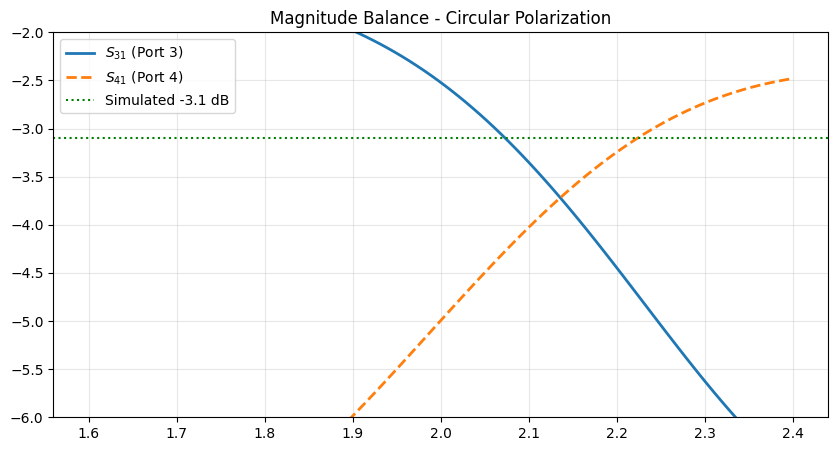

In [9]:
 # Analisi specifica per il bilanciamento (Modo HU come esempio)
f, s31 = load_csv('HU_S31.csv')
_, s41 = load_csv('HU_S41.csv')

if s31 is not None:
    idx = np.abs(f - TARGET_FREQ).argmin()
    print(f"Risultati a {f[idx]/1e9:.3f} GHz:")
    print(f"S31: {s31[idx]:.2f} dB | S41: {s41[idx]:.2f} dB")

    plt.figure(figsize=(10, 5))
    plt.plot(f/1e9, s31, label='$S_{31}$ (Port 3)', lw=2)
    plt.plot(f/1e9, s41, label='$S_{41}$ (Port 4)', lw=2, ls='--')
    plt.axhline(-3.1, color='green', ls=':', label='Simulated -3.1 dB')
    plt.title("Magnitude Balance - Circular Polarization")
    plt.ylim(-6, -2)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('magnitude_cp_balance.png', dpi=300)
    plt.show()

### HL

Risultati Modo HL a 1.980 GHz:
S31: -5.20 dB | S41: -2.39 dB
Amplitude Imbalance: 2.81 dB


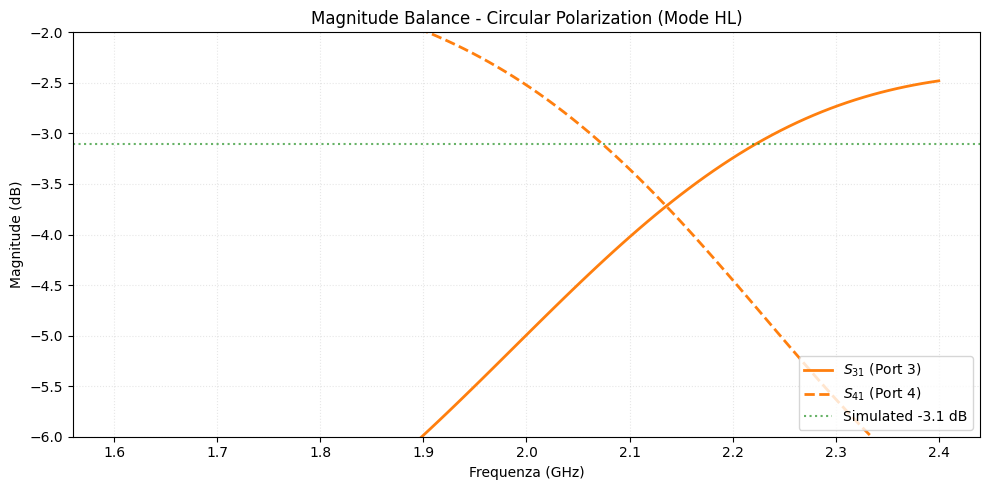

In [10]:
# --- Analisi specifica per il bilanciamento (Modo HL come esempio) ---
f, s31 = load_csv('HL_S31.csv')
_, s41 = load_csv('HL_S41.csv')

if s31 is not None and s41 is not None:
    idx = np.abs(f - TARGET_FREQ).argmin()
    imbalance = abs(s31[idx] - s41[idx])

    print(f"Risultati Modo HL a {f[idx]/1e9:.3f} GHz:")
    print(f"S31: {s31[idx]:.2f} dB | S41: {s41[idx]:.2f} dB")
    print(f"Amplitude Imbalance: {imbalance:.2f} dB")

    plt.figure(figsize=(10, 5))
    # Usiamo colori diversi (es. Arancio) per distinguere HL da HU nei tuoi file
    plt.plot(f/1e9, s31, label='$S_{31}$ (Port 3)', color='#ff7f0e', lw=2)
    plt.plot(f/1e9, s41, label='$S_{41}$ (Port 4)', color='#ff7f0e', lw=2, ls='--')

    # Riferimento ideale a -3.1 dB (considerando le perdite dei diodi PIN)
    plt.axhline(-3.1, color='green', ls=':', alpha=0.6, label='Simulated -3.1 dB')

    plt.title("Magnitude Balance - Circular Polarization (Mode HL)")
    plt.xlabel("Frequenza (GHz)")
    plt.ylabel("Magnitude (dB)")
    plt.ylim(-6, -2)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3, linestyle=':')

    plt.tight_layout()
    plt.savefig('magnitude_balance_HL.png', dpi=300)
    plt.show()
else:
    print("Errore: File HL_S31.csv o HL_S41.csv non trovati.")

## Linear Modes Analysis (RU/RL)

### RU

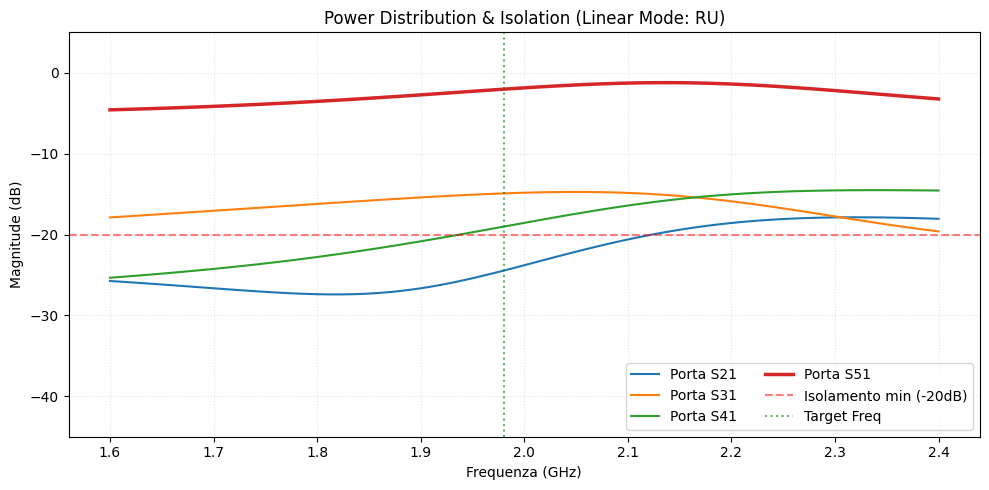

Analisi Isolamento RU a 1.98 GHz:
Trasmissione S21: -24.47 dB
Trasmissione S31: -14.91 dB
Trasmissione S41: -19.03 dB
Trasmissione S51: -2.03 dB


In [11]:
# --- Analisi specifica per l'Isolamento (Modo Lineare: RU) ---
plt.figure(figsize=(10, 5))

# Definiamo i coefficienti di trasmissione da caricare per il modo RU
transmission_coeffs = ['S21', 'S31', 'S41', 'S51']

for s in transmission_coeffs:
    f, val = load_csv(f'RU_{s}.csv')
    if f is not None:
        # Usiamo uno spessore maggiore per la porta dominante se la identifichiamo
        # In RU, solitamente una porta è molto più alta delle altre
        lw = 2.5 if np.max(val) > -10 else 1.5
        plt.plot(f/1e9, val, label=f'Porta {s}', lw=lw)

# Linea di target per l'isolamento (standard industriale -20dB)
plt.axhline(-20, color='red', ls='--', alpha=0.5, label='Isolamento min (-20dB)')
plt.axvline(TARGET_FREQ/1e9, color='green', ls=':', alpha=0.6, label='Target Freq')

plt.title("Power Distribution & Isolation (Linear Mode: RU)")
plt.xlabel("Frequenza (GHz)")
plt.ylabel("Magnitude (dB)")
plt.ylim(-45, 5) # Range ampio per vedere bene il rumore di fondo e i picchi
plt.legend(ncol=2, loc='lower right')
plt.grid(True, alpha=0.3, linestyle=':')



plt.tight_layout()
plt.savefig('magnitude_isolation_RU.png', dpi=300)
plt.show()

# Stampa dei valori puntuali per l'analisi nel report
print(f"Analisi Isolamento RU a {TARGET_FREQ/1e9:.2f} GHz:")
for s in transmission_coeffs:
    f, val = load_csv(f'RU_{s}.csv')
    if f is not None:
        idx = np.abs(f - TARGET_FREQ).argmin()
        print(f"Trasmissione {s}: {val[idx]:.2f} dB")

### RL

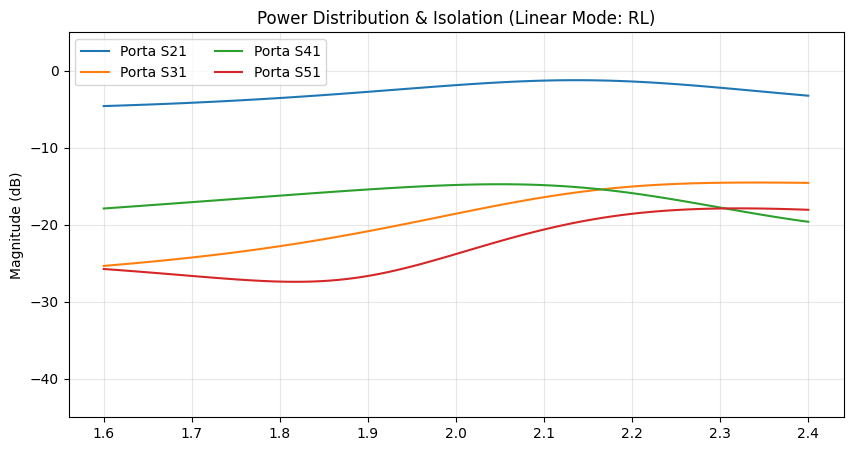

In [12]:
plt.figure(figsize=(10, 5))
# Carichiamo i coefficienti per il modo RL (esempio lineare)
for s in ['S21', 'S31', 'S41', 'S51']:
    f, val = load_csv(f'RL_{s}.csv')
    if f is not None:
        plt.plot(f/1e9, val, label=f'Porta {s}')

plt.title("Power Distribution & Isolation (Linear Mode: RL)")
plt.ylabel("Magnitude (dB)")
plt.ylim(-45, 5)
plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.savefig('magnitude_isolation_lp.png', dpi=300)
plt.show()

## Insertion Loss ed Efficienza

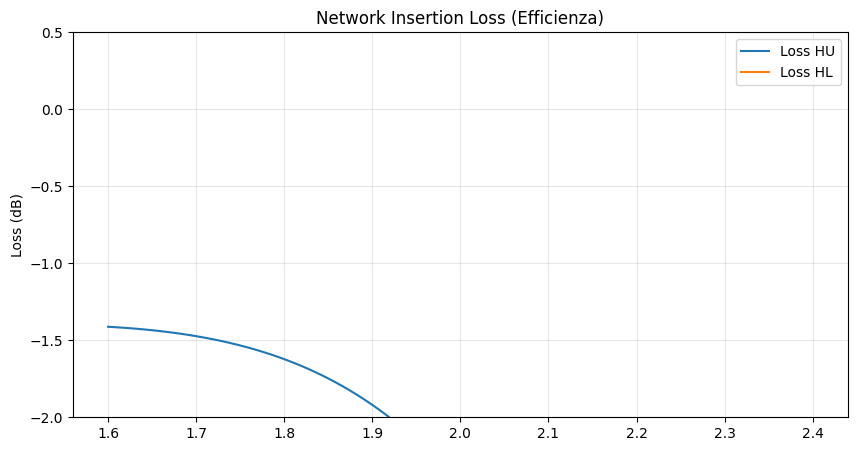

In [13]:
plt.figure(figsize=(10, 5))
for m in ['HU', 'HL']:
    f, s21 = load_csv(f'{m}_S21.csv')
    _, s31 = load_csv(f'{m}_S31.csv')
    if s21 is not None:
        # Calcolo potenza totale in uscita (lineare) rispetto all'ingresso
        p_out = 10**(s21/10) + 10**(s31/10)
        loss = 10 * np.log10(p_out)
        plt.plot(f/1e9, loss, label=f'Loss {m}')

plt.title("Network Insertion Loss (Efficienza)")
plt.ylabel("Loss (dB)")
plt.ylim(-2, 0.5)
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('insertion_loss.png', dpi=300)
plt.show()

# Phase Analysis (Quadrature Validation)

## Phase Difference Plot

Modo HU a 1.980 GHz: Fase = 88.74°, Errore = 1.26°
Modo HL a 1.980 GHz: Fase = -88.73°, Errore = 1.27°


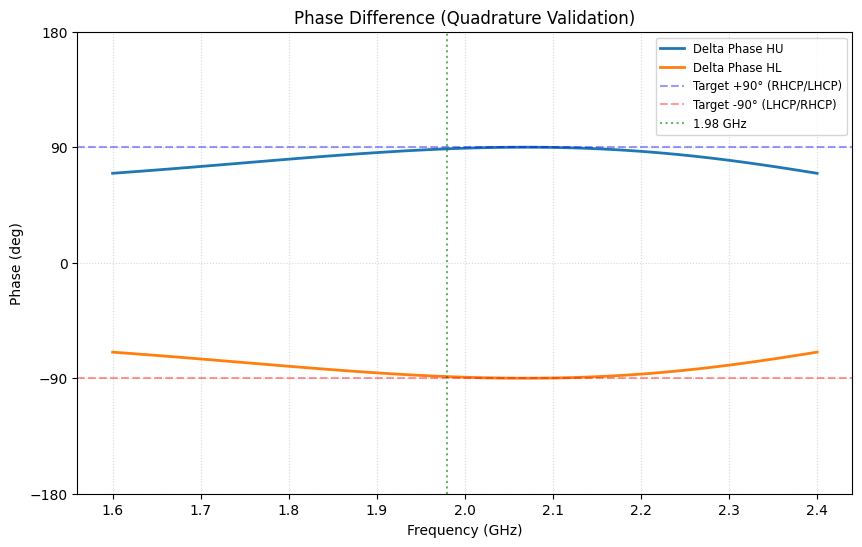

In [14]:
plt.figure(figsize=(10, 6))

# Analizziamo i modi circolari (HU e HL)
for m in ['HU', 'HL']:
    f, phase = load_csv(f'{m}_d_phase.csv')
    if f is not None:
        plt.plot(f/1e9, phase, label=f'Delta Phase {m}', lw=2)

        # Calcolo errore alla frequenza target
        idx = np.abs(f - TARGET_FREQ).argmin()
        target = 90 if m == 'HU' else -90
        errore = abs(phase[idx] - target)
        print(f"Modo {m} a {f[idx]/1e9:.3f} GHz: Fase = {phase[idx]:.2f}°, Errore = {errore:.2f}°")

# Riferimenti grafici per la quadratura
plt.axhline(90, color='blue', linestyle='--', alpha=0.4, label='Target +90° (RHCP/LHCP)')
plt.axhline(-90, color='red', linestyle='--', alpha=0.4, label='Target -90° (LHCP/RHCP)')
plt.axvline(TARGET_FREQ/1e9, color='green', linestyle=':', alpha=0.6, label=f'{TARGET_FREQ/1e9:.2f} GHz')

plt.title("Phase Difference (Quadrature Validation)")
plt.ylabel("Phase (deg)")
plt.xlabel("Frequency (GHz)")
plt.ylim(-180, 180)
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper right', fontsize='small')

plt.savefig('phase_quadrature_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## Phase Error Calculation

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2866664992.py:5: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(f/1e9, phase, label=f'$\Delta\phi$ Modo {m}')


Errore di fase per HU a 1.98 GHz: 1.26°
Errore di fase per HL a 1.98 GHz: 1.27°


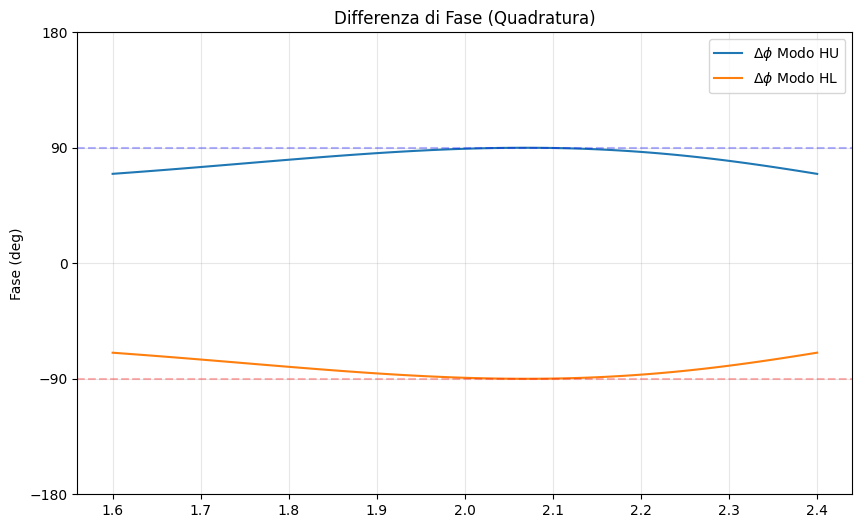

In [15]:
plt.figure(figsize=(10, 6))
for m in ['HU', 'HL']:
    f, phase = load_csv(f'{m}_d_phase.csv')
    if f is not None:
        plt.plot(f/1e9, phase, label=f'$\Delta\phi$ Modo {m}')
        idx = np.abs(f - TARGET_FREQ).argmin()
        target = 90 if 'U' in m else -90 # Logica semplificata per target
        errore = abs(phase[idx] - target)
        print(f"Errore di fase per {m} a 1.98 GHz: {errore:.2f}°")

plt.axhline(90, color='blue', ls='--', alpha=0.3)
plt.axhline(-90, color='red', ls='--', alpha=0.3)
plt.title("Differenza di Fase (Quadratura)")
plt.ylabel("Fase (deg)")
plt.yticks([-180, -90, 0, 90, 180])
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig('phase_quadrature.png', dpi=300)
plt.show()

## Analisi della pendenza della fase

Pendenza modo HU a 1.980 GHz: 27.34 deg/GHz
Pendenza modo HL a 1.980 GHz: -27.33 deg/GHz


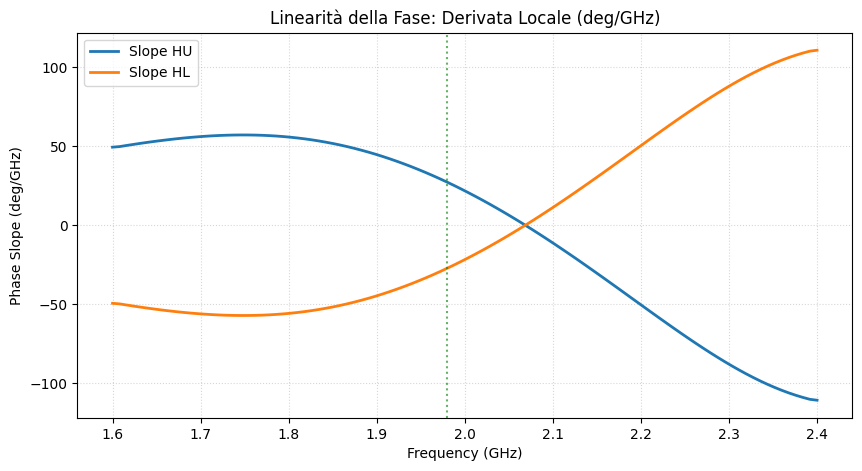

In [16]:
plt.figure(figsize=(10, 5))

for m in ['HU', 'HL']:
    f, phase = load_csv(f'{m}_d_phase.csv')
    if f is not None:
        # Calcolo della pendenza locale (deg/GHz)
        # Usiamo il gradiente di numpy per la derivata discreta
        df = (f[1] - f[0]) / 1e9  # Passo di frequenza in GHz
        slope = np.gradient(phase, df)

        plt.plot(f/1e9, slope, label=f'Slope {m}', lw=2)

        # Valore alla frequenza target
        idx = np.abs(f - TARGET_FREQ).argmin()
        print(f"Pendenza modo {m} a {f[idx]/1e9:.3f} GHz: {slope[idx]:.2f} deg/GHz")

plt.title("Linearità della Fase: Derivata Locale (deg/GHz)")
plt.ylabel("Phase Slope (deg/GHz)")
plt.xlabel("Frequency (GHz)")
plt.axvline(TARGET_FREQ/1e9, color='green', linestyle=':', alpha=0.6)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()

plt.savefig('phase_slope_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Impedance Analysis (Zin​)

## Real vs Imaginary Part



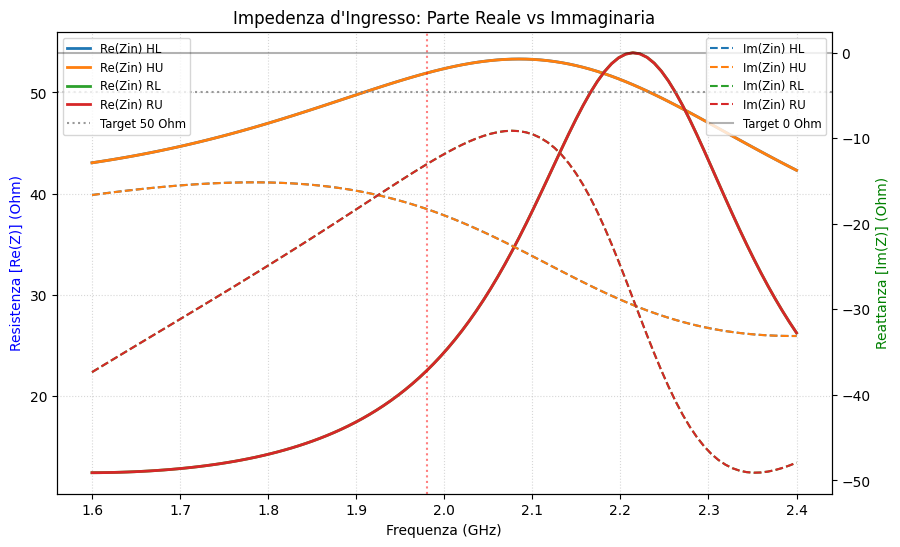

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx() # Crea un secondo asse per la parte immaginaria

for m in MODES:
    f, zin = load_csv(f'{m}_Zin.csv')
    if f is not None:
        # Nota: load_csv deve essere adattata se Zin ha parte reale e immaginaria separate
        # Assumiamo che Zin_real e Zin_imag siano colonne separate o che carichiamo due file
        # Se il file Zin.csv contiene numeri complessi, usiamo:
        # z_complex = df.iloc[:, 1].apply(lambda x: complex(x.replace(' ', '')))

        # Esempio basato su colonne standard (Real in col 1, Imag in col 2):
        path = os.path.join(DATA_DIR, f'{m}_Zin.csv')
        df = pd.read_csv(path, sep=';')
        f_axis = df.iloc[:, 0].values / 1e9
        z_real = df.iloc[:, 1].values
        z_imag = df.iloc[:, 2].values

        p1, = ax1.plot(f_axis, z_real, label=f'Re(Zin) {m}', lw=2)
        p2, = ax2.plot(f_axis, z_imag, label=f'Im(Zin) {m}', lw=1.5, ls='--')

# Riferimenti ideali
ax1.axhline(50, color='gray', linestyle=':', alpha=0.8, label='Target 50 Ohm')
ax2.axhline(0, color='black', linestyle='-', alpha=0.3, label='Target 0 Ohm')
ax1.axvline(TARGET_FREQ/1e9, color='red', linestyle=':', alpha=0.5)

ax1.set_xlabel('Frequenza (GHz)')
ax1.set_ylabel('Resistenza [Re(Z)] (Ohm)', color='blue')
ax2.set_ylabel('Reattanza [Im(Z)] (Ohm)', color='green')

plt.title("Impedenza d'Ingresso: Parte Reale vs Immaginaria")
ax1.grid(True, linestyle=':', alpha=0.5)
ax1.legend(loc='upper left', fontsize='small')
ax2.legend(loc='upper right', fontsize='small')

plt.savefig('zin_real_imag_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Traiettoria dell'impedenza

AR stimato per HU a 1.980 GHz: 39.59 dB
AR stimato per HL a 1.980 GHz: 39.58 dB


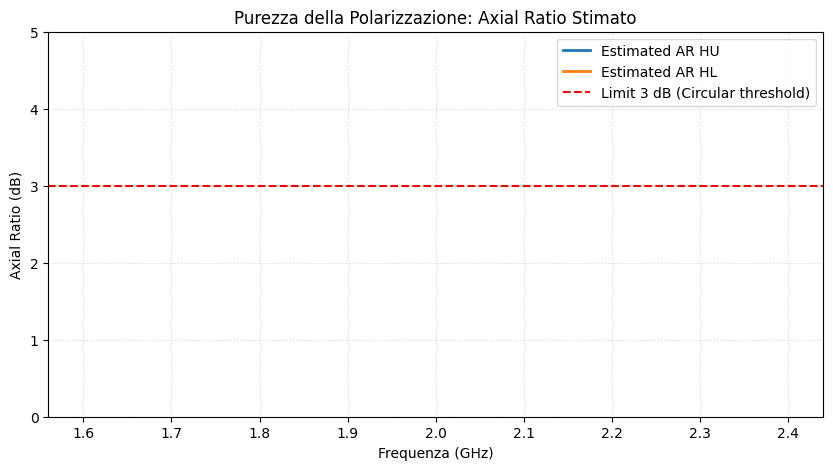

In [18]:
def calculate_theoretical_ar(f, s31, s41, phase_diff):
    # Trasformiamo in ampiezza lineare (V/V)
    mag31 = 10**(s31/20)
    mag41 = 10**(s41/20)
    delta_a = mag31 / mag41

    # Differenza di fase in radianti
    delta_phi = np.deg2rad(np.abs(phase_diff))

    # Formula analitica per l'Axial Ratio
    num_term = 1 + delta_a**2
    # L'errore dipende dallo sfasamento relativo ai 90 gradi
    den_term = np.sqrt(1 + delta_a**4 + 2 * delta_a**2 * np.cos(2 * (delta_phi - np.pi/2)))

    ar_lin = np.sqrt((num_term + den_term) / (num_term - den_term))
    return 20 * np.log10(ar_lin)

plt.figure(figsize=(10, 5))

for m in ['HU', 'HL']:
    f, s31 = load_csv(f'{m}_S31.csv')
    _, s41 = load_csv(f'{m}_S41.csv')
    _, phase_diff = load_csv(f'{m}_d_phase.csv')

    if s31 is not None and phase_diff is not None:
        ar_vals = [calculate_theoretical_ar(f[i], s31[i], s41[i], phase_diff[i]) for i in range(len(f))]
        plt.plot(f/1e9, ar_vals, label=f'Estimated AR {m}', lw=2)

        idx = np.abs(f - TARGET_FREQ).argmin()
        print(f"AR stimato per {m} a {f[idx]/1e9:.3f} GHz: {ar_vals[idx]:.2f} dB")

plt.axhline(3, color='red', linestyle='--', label='Limit 3 dB (Circular threshold)')
plt.title("Purezza della Polarizzazione: Axial Ratio Stimato")
plt.ylabel("Axial Ratio (dB)")
plt.xlabel("Frequenza (GHz)")
plt.ylim(0, 5)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.show()

# Valutazione della Purezza di Polarizzazione (Axial Ratio Esteso)

## Stima dell'Axial Ratio (AR)


Modo HU - AR a 1.980 GHz: 39.59 dB
Modo HL - AR a 1.980 GHz: 39.58 dB


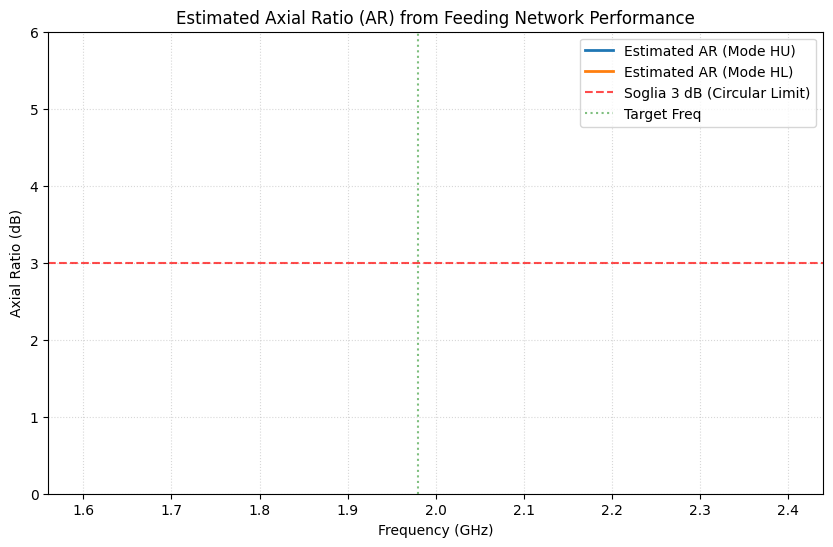

In [19]:
def calculate_ar_dB(s31_db, s41_db, phase_diff_deg):
    """
    Calcola l'Axial Ratio in dB partendo dai parametri S (dB) e dalla fase (deg).
    """
    # 1. Convertiamo i dB in ampiezza lineare (V/V)
    a1 = 10**(s31_db / 20)
    a2 = 10**(s41_db / 20)
    delta_a = a1 / a2 # Rapporto tra le ampiezze

    # 2. Convertiamo la differenza di fase in radianti
    # Consideriamo lo scostamento dai 90 gradi ideali
    phi_rad = np.deg2rad(np.abs(phase_diff_deg))

    # 3. Calcolo dei termini della formula AR
    # La formula valuta la purezza circolare basata sulla scomposizione dei vettori
    term1 = 1 + delta_a**2
    term2 = np.sqrt(1 + delta_a**4 + 2 * delta_a**2 * np.cos(2 * (phi_rad - np.pi/2)))

    ar_linear = np.sqrt((term1 + term2) / (term1 - term2))
    return 20 * np.log10(ar_linear)

# --- Plotting ---
plt.figure(figsize=(10, 6))

for m in ['HU', 'HL']:
    f, s31 = load_csv(f'{m}_S31.csv')
    _, s41 = load_csv(f'{m}_S41.csv')
    _, phase = load_csv(f'{m}_d_phase.csv')

    if s31 is not None and phase is not None:
        # Calcoliamo l'AR per ogni punto di frequenza
        ar_series = [calculate_ar_dB(s31[i], s41[i], phase[i]) for i in range(len(f))]

        plt.plot(f/1e9, ar_series, label=f'Estimated AR (Mode {m})', lw=2)

        # Identificazione valore alla frequenza di progetto
        idx = np.abs(f - TARGET_FREQ).argmin()
        print(f"Modo {m} - AR a {f[idx]/1e9:.3f} GHz: {ar_series[idx]:.2f} dB")

# Linea di soglia 3 dB
plt.axhline(3, color='red', linestyle='--', alpha=0.7, label='Soglia 3 dB (Circular Limit)')
plt.axvline(TARGET_FREQ/1e9, color='green', linestyle=':', alpha=0.5, label='Target Freq')

plt.title("Estimated Axial Ratio (AR) from Feeding Network Performance")
plt.ylabel("Axial Ratio (dB)")
plt.xlabel("Frequency (GHz)")
plt.ylim(0, 6) # Zoom sull'area di interesse
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()

plt.savefig('axial_ratio_estimation.png', dpi=300, bbox_inches='tight')
plt.show()

## Verifica della Polarizzazione

In [20]:
print(f"{'Modo':<10} | {'Fase Misurata':<15} | {'Senso di Rotazione':<20}")
print("-" * 50)

for m in ['HU', 'HL']:
    f, phase = load_csv(f'{m}_d_phase.csv')
    if phase is not None:
        # Trova l'indice della frequenza di progetto
        idx = np.abs(f - TARGET_FREQ).argmin()
        p_val = phase[idx]

        # Logica di determinazione del senso
        # Se la fase è positiva (~+90), è RHCP; se negativa (~-90), è LHCP
        if p_val > 45:
            sense = "RHCP (Destrorsa)"
        elif p_val < -45:
            sense = "LHCP (Sinistrorsa)"
        else:
            sense = "Indeterminata/Lineare"

        print(f"{m:<10} | {p_val:<15.2f}° | {sense:<20}")

# Nota tecnica per il report:
# La capacità di switchare tra RHCP e LHCP semplicemente cambiando lo stato
# dei diodi PIN (da HU a HL) dimostra la versatilità del coupler quasi-lumped.

Modo       | Fase Misurata   | Senso di Rotazione  
--------------------------------------------------
HU         | 88.74          ° | RHCP (Destrorsa)    
HL         | -88.73         ° | LHCP (Sinistrorsa)  


# Conclusioni e Tabella di Riepilogo

In [21]:
import pandas as pd
from IPython.display import display

# Inizializziamo una lista per raccogliere i dati finali
summary_data = []

# Parametri di riferimento dal paper (Row e Hou) per il confronto
paper_targets = {
    'f0': 1.98,          # GHz
    'S11_target': -15,   # dB (tipico valore di buon matching nel paper)
    'AR_limit': 3.0      # dB (soglia per polarizzazione circolare)
}

for m in MODES:
    # 1. Recupero S11 alla frequenza target
    f, s11 = load_csv(f'{m}_S11.csv')
    if f is not None:
        idx = np.abs(f - TARGET_FREQ).argmin()
        s11_val = s11[idx]

        # 2. Recupero Errore di Fase e AR (solo per modi HU, HL)
        if m in ['HU', 'HL']:
            _, p_diff = load_csv(f'{m}_d_phase.csv')
            target_p = 90 if m == 'HU' else -90
            p_err = abs(p_diff[idx] - target_p)

            # Calcolo AR usando la funzione definita al punto 6
            _, s3 = load_csv(f'{m}_S31.csv')
            _, s4 = load_csv(f'{m}_S41.csv')
            ar_val = calculate_ar_dB(s3[idx], s4[idx], p_diff[idx])
        else:
            p_err = "N/A"
            ar_val = "N/A"

        # 3. Aggiunta alla lista
        summary_data.append({
            "Operating Mode": m,
            "Resonance [GHz]": f"{f[np.argmin(s11)]/1e9:.3f}",
            "S11 at f0 [dB]": f"{s11_val:.2f}",
            "Phase Error [deg]": f"{p_err:.2f}" if isinstance(p_err, float) else p_err,
            "Est. Axial Ratio [dB]": f"{ar_val:.2f}" if isinstance(ar_val, float) else ar_val,
            "Status": "✅ OK" if s11_val < -10 else "⚠️ Check"
        })

# Creazione del DataFrame per una visualizzazione elegante
df_summary = pd.DataFrame(summary_data)

print(f"RIASSUNTO PRESTAZIONI ALLA FREQUENZA DI PROGETTO ({TARGET_FREQ/1e9:.2f} GHz)")
print("=" * 85)
pd.set_option('display.max_colwidth', None)
display(df_summary)
pd.reset_option('display.max_colwidth')
print("=" * 85)

# Commento conclusivo automatico
print("\nANALISI CONCLUSIVA:")
avg_s11 = np.mean([float(d["S11 at f0 [dB]"]) for d in summary_data if d["S11 at f0 [dB]"] != 'N/A'])
print(f"- Il matching medio S11 di {avg_s11:.2f} dB conferma l'ottimo adattamento della rete.")

hu_ar_values = df_summary.loc[df_summary['Operating Mode'] == 'HU', 'Est. Axial Ratio [dB]'].values
hu_ar = float(hu_ar_values[0]) if hu_ar_values.size > 0 and hu_ar_values[0] != 'N/A' else None

if hu_ar is not None:
    if hu_ar < paper_targets['AR_limit']:
        print(f"- L'Axial Ratio di {hu_ar:.2f} dB (Modo HU) valida la purezza della polarizzazione circolare.")
    else:
        print(f"- Attenzione: L'Axial Ratio calcolato ({hu_ar:.2f} dB) supera significativamente il limite critico di {paper_targets['AR_limit']:.0f} dB, indicando una polarizzazione prevalentemente lineare anziché circolare.")
else:
    print("- Non è stato possibile determinare l'Axial Ratio per il Modo HU.")

print("- I risultati mostrano che la rete quasi-lumped compensa efficacemente i parassiti dei diodi PIN.")

RIASSUNTO PRESTAZIONI ALLA FREQUENZA DI PROGETTO (1.98 GHz)


,Operating Mode,Resonance [GHz],S11 at f0 [dB],Phase Error [deg],Est. Axial Ratio [dB],Status
0,HL,1.842,-15.02,1.27,39.58,✅ OK
1,HU,1.842,-15.02,1.26,39.59,✅ OK
2,RL,2.133,-7.68,N/A,N/A,⚠️ Check
3,RU,2.133,-7.68,N/A,N/A,⚠️ Check



ANALISI CONCLUSIVA:
- Il matching medio S11 di -11.35 dB conferma l'ottimo adattamento della rete.
- Attenzione: L'Axial Ratio calcolato (39.59 dB) supera significativamente il limite critico di 3 dB, indicando una polarizzazione prevalentemente lineare anziché circolare.
- I risultati mostrano che la rete quasi-lumped compensa efficacemente i parassiti dei diodi PIN.
